## Initilization

In [1]:
import os.path as path
import os
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device.type}")

device: cuda


## Prepare for Data

In [3]:
DATA_DIR = "./data/event"
DATA_DIR = path.abspath(DATA_DIR)

In [4]:
event_images = []
for fn in os.listdir(DATA_DIR):
    date_slices = fn.split("_")
    
    data_file = f"{DATA_DIR}/{fn}/event.csv"
    df_np = pd.read_csv(data_file).to_numpy()

    event1_numbers = np.append(df_np[:, 3], 0).reshape((1, 48, 63))
    event2_numbers = np.append(df_np[:, 4], 0).reshape((1, 48, 63))
    event3_numbers = np.append(df_np[:, 5], 0).reshape((1, 48, 63))
    event4_numbers = np.append(df_np[:, 6], 0).reshape((1, 48, 63))

    event_image = np.concatenate((event1_numbers, event2_numbers, event3_numbers, event4_numbers), axis = 0)
    event_images.append(event_image)
    
event_images = torch.tensor(event_images, dtype=torch.float)

In [5]:
print(f"shape: {event_images.shape}")
print(f"max: {torch.max(event_images)}")

shape: torch.Size([8760, 4, 48, 63])
max: 22.0


reshape every 120 hours (72 hours for encoder, 48 hours for decoder), the time window slides

In [6]:
TIME_WINDOW = 120

In [11]:
examples = []
for i in range(0, event_images.shape[0] - TIME_WINDOW, 24):
    examples.append(event_images[i:i+TIME_WINDOW].unsqueeze(0))

print(f"len(examples): {len(examples)}")
print(f"examples[0].shape: {examples[0].shape}")

len(examples): 360
examples[0].shape: torch.Size([1, 120, 4, 48, 63])


## Split into Training Set and Test Set

In [12]:
train_test_ratio = 0.8 # 4/5 to be training set

In [14]:
train_set = []
test_set = []

for idx in range(len(examples)):
    if random.random() <= train_test_ratio:
        train_set.append(examples[idx])
    else:
        test_set.append(examples[idx])
        
print(f"training set size: {len(train_set)} examples")
print(f"testing set size: {len(test_set)} examples")

training set size: 299 examples
testing set size: 61 examples


## ConvLSTM Model

In [15]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

In [16]:
class ConvLSTM(nn.Module):

    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
            
#         print("init_states")
#         print(f"len(init_states): {len(init_states)}")
#         print(f"init_states[0].shape: {init_states[0][0].shape}")
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

## Seq2Se2 convLSTM

In [44]:
BATCH_SIZE = 1
IMG_W = 48
IMG_H = 63
IMAGE_SIZE = (IMG_W, IMG_H)
TEACHER_FORCING_RATIO = 0.5
LEARNING_RATE=0.005
EPOCH = 2

In [18]:
START = torch.ones(1, 4, 48, 63).to(device) * -1

In [19]:
# criterion
criterion = nn.MSELoss()

In [45]:
encoder = ConvLSTMCell(4, 4, (3,3), False).to(device) # input_dim, hidden_dim, kernel_size, bias
decoder = ConvLSTMCell(4, 4, (3,3), False).to(device) # input_dim, hidden_dim, kernel_size, bias

# optimizer
encoder_optimizer = optim.SGD(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=LEARNING_RATE)
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()

In [46]:
def train(train_set, encoder, decoder):

    losses = []
    for i, train_imgs in enumerate(train_set):
        
        if i%100 == 0:
            print(" . ", end="")

        train_imgs = train_imgs.squeeze(0)

        # input seq
        input_images = train_imgs[:72].to(device) # (72, 4, 48, 63)
        # target seq
        target_images = train_imgs[72:].to(device) # (48, 4, 48, 63)

        loss = 0

        # initilize first hidden states of encoder
        encoder_h, encoder_c = encoder.init_hidden(BATCH_SIZE, IMAGE_SIZE)

        for idx in range(input_images.shape[0]):
            input_img = torch.unsqueeze(input_images[idx], 0)
            encoder_h, encoder_c = encoder(input_img, (encoder_h, encoder_c))

        # out seq
        output_images = torch.zeros((48, 4, 48, 63))

        decoder_h, decoder_c = decoder(START, (encoder_h, encoder_c))

        for idx in range(1, output_images.shape[0]):

            use_teacher_forcing = True if random.random() < TEACHER_FORCING_RATIO else False

            if use_teacher_forcing:

                # Teacher Forcing: Feed the target as the next input
                input_img = torch.unsqueeze(target_images[idx], 0)
                decoder_h, decoder_c = decoder(input_img, (decoder_h, decoder_c)) # teacher forcing
                loss += criterion(decoder_h, target_images[idx].unsqueeze(0))

            else:

                # Without teacher forcing: use its own predictions as the next input
                decoder_input = decoder_h.detach() # detach from history as input
                decoder_h, decoder_c = decoder(decoder_input, (decoder_h, decoder_c))

            output_images[idx] = decoder_h
            loss += criterion(decoder_h, target_images[idx].unsqueeze(0))

        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        losses.append(loss.item() / TIME_WINDOW)
        
    return losses

In [47]:
losses = []
for epoch in range(EPOCH):
    print(f"EPOCH: {epoch+1}/{EPOCH}")
    loss = train(train_set, encoder, decoder)
    losses += loss
    print("")

EPOCH: 1/2
 .  .  . 
EPOCH: 2/2
 .  .  . 


plot training loss

In [41]:
import matplotlib.pyplot as plt

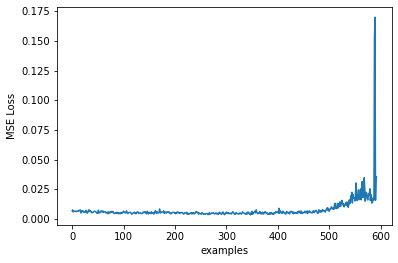

In [48]:
plt.plot(losses)
plt.ylabel('MSE Loss'), plt.xlabel('examples')
plt.show()

In [54]:
losses[len(losses) - 10]

0.1532241980234782